In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = 'cuda'

In [3]:
torch.manual_seed(42)

In [4]:
df = pd.read_csv('../../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [5]:
def MARE(prediction_tensor, truth_tensor):
    epsilon = 1e-8  # Small value to prevent division by zero
    # print(torch.abs((prediction_tensor - truth_tensor)) / torch.abs(truth_tensor + epsilon))
    return (torch.sum(torch.abs((prediction_tensor - truth_tensor)) / torch.abs(truth_tensor + epsilon))) / truth_tensor.numel()

In [6]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [7]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [8]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [9]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [ ]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]


# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device=device)  # (batch, output_dim)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to(device)  # Use "cuda" if you have a GPU
# criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)

In [ ]:
num_epochs = 300
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model1.train()
    
        optimizer1.zero_grad()
        y_pred = model1(train_seq_tensor1[i])
        loss = MARE(y_pred, train_label_tensor1[i])
        # print(y_pred)
        # print(loss.item())
        loss.backward()
        optimizer1.step()
    
        train_losses.append(loss.item())

    # Validation
    model1.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model1(val_seq_tensor1[i])
                val_loss = MARE(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 226.91236877441406, Val Loss: 225.58749389648438
Epoch 10, Train Loss: 189.15106201171875, Val Loss: 187.83265686035156
Epoch 20, Train Loss: 152.4259033203125, Val Loss: 151.1075439453125
Epoch 30, Train Loss: 115.89524841308594, Val Loss: 114.57691955566406
Epoch 40, Train Loss: 79.39263916015625, Val Loss: 78.07432556152344
Epoch 50, Train Loss: 42.89208984375, Val Loss: 41.573760986328125
Epoch 60, Train Loss: 6.39190673828125, Val Loss: 5.073577880859375
Epoch 70, Train Loss: 8.727981567382812, Val Loss: 9.994522094726562
Epoch 80, Train Loss: 8.801361083984375, Val Loss: 10.067214965820312
Epoch 90, Train Loss: 8.798736572265625, Val Loss: 10.06439208984375
Epoch 100, Train Loss: 8.798049926757812, Val Loss: 10.063644409179688
Epoch 110, Train Loss: 8.797775268554688, Val Loss: 10.063385009765625
Epoch 120, Train Loss: 8.79779052734375, Val Loss: 10.063400268554688
Epoch 130, Train Loss: 8.797821044921875, Val Loss: 10.063430786132812
Epoch 140, Train Loss: 8

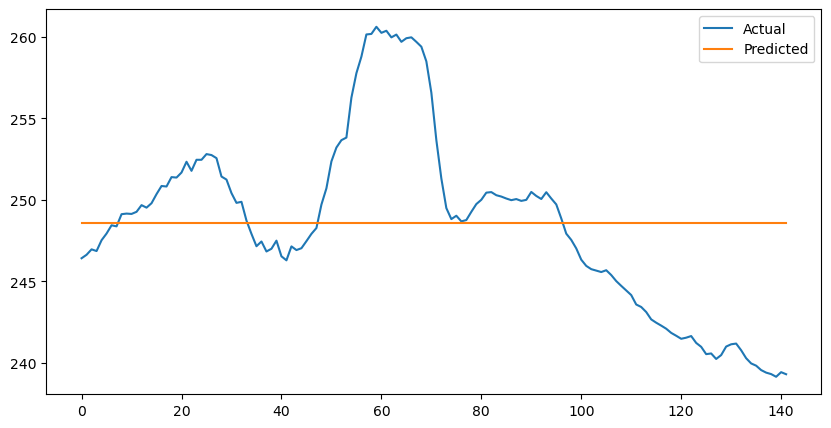

In [24]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(train_seq_tensor1)):
        pred = model1(train_seq_tensor1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [14]:
y_pred_t = torch.FloatTensor(y_pred).to(device='cuda')

print(y_pred_t)

tensor([248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.5958,
        248.5958, 248.5958, 248.5958, 248.5958, 248.5958, 248.59

In [15]:
train_label_tensor1.squeeze(1)

tensor([246.4242, 246.6372, 246.9698, 246.8667, 247.5300, 247.9409, 248.4472,
        248.3813, 249.1277, 249.1647, 249.1433, 249.2732, 249.6824, 249.5295,
        249.8006, 250.3587, 250.8578, 250.8272, 251.4033, 251.3751, 251.6841,
        252.3453, 251.7886, 252.4662, 252.4659, 252.8155, 252.7561, 252.5665,
        251.4379, 251.2519, 250.4210, 249.8228, 249.8874, 248.7369, 247.9199,
        247.1620, 247.4535, 246.8398, 247.0067, 247.5040, 246.5427, 246.2970,
        247.1524, 246.9264, 247.0399, 247.4743, 247.9212, 248.2795, 249.7169,
        250.7162, 252.3669, 253.2182, 253.6707, 253.8298, 256.2766, 257.7786,
        258.7948, 260.1566, 260.1900, 260.6283, 260.2567, 260.3839, 259.9782,
        260.1497, 259.7054, 259.9262, 259.9806, 259.7025, 259.4044, 258.5042,
        256.5838, 253.6745, 251.3210, 249.5032, 248.8258, 249.0325, 248.6864,
        248.7686, 249.2724, 249.7473, 250.0116, 250.4492, 250.4831, 250.2928,
        250.2095, 250.0893, 249.9887, 250.0554, 249.9438, 250.00

In [16]:
MARE(y_pred_t, train_label_tensor1)

tensor(2.4113, device='cuda:0')

In [17]:
0.0809/0.3538

0.22866026003391746

In [18]:
y_hat = y_pred_t[0]
y_hat

tensor(248.5958, device='cuda:0')

In [19]:
y = train_label_tensor1[0]

In [20]:
torch.abs(y_hat - y)/ torch.abs(y)

tensor([0.0088], device='cuda:0')

In [21]:
y_hat = y_hat.cpu().item() * train_std1 + train_mean1
y = y.cpu().item() *  train_std1 + train_mean1

NameError: name 'train_std1' is not defined

In [ ]:
np.abs((y_hat) - (y))/np.abs(y)

O2_avg    0.002048
dtype: float64

In [ ]:
y_hat

O2_avg    246.928949
dtype: float64

In [ ]:
y

O2_avg    246.424199
dtype: float64

In [ ]:
(y_hat - train_mean1)/train_std1

O2_avg   -0.259955
dtype: float64

In [ ]:
(y - train_mean1)/train_std1

O2_avg   -0.353809
dtype: float64